## Set up the Notebook

In [1]:
# Import modules
import pandas as pd
import numpy as np
import pyarrow as pa
import pyarrow.parquet as pq
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import torch
import pickle
import os

## Import and Process the Images (Data Wrangling)

In [2]:
# Import the training images.  Images are 137 x 236.
# train_image_0 = pq.read_table('storage/training/train_image_data_0.parquet').to_pandas().set_index('image_id')
# train_image_1 = pq.read_table('/storage/training/train_image_data_1.parquet').to_pandas().set_index('image_id')
# train_image_2 = pq.read_table('/storage/train_image_data_2.parquet').to_pandas().set_index('image_id')
# train_image_3 = pq.read_table('/storage/train_image_data_3.parquet').to_pandas().set_index('image_id')

if torch.cuda.is_available():
    device = torch.device('cuda:0')
    
with open('train_image_torch.pickle', 'rb') as f:
    
    train_image_torch = pickle.load(f).to(device)


#import the training csv (Includes all three files)
train_data = pd.read_csv('/storage/train.csv').set_index('image_id')

In [5]:
train_image_numpy = train_image_torch.cpu().numpy()

In [6]:
# Set processing Parameters

# Set the threshold for converting images to binary
bw_threshold = 200

In [16]:
# Define a function that will plot an image given the image id
def plot_letter(index, source_df, dimensions=(137, 236), vmax=255):
  ''' Plots image from dataframe containing image 
  image_id: string of image id to search in table
  source_df: source dataframe
  dimensions: defaults 137 x 236, must be tuple
  vmax = defines value for maximum darkness in the data, default 255'''

  # img = source_df[image_id].values.reshape(dimensions)
  # initialize an empty image
  img = np.empty(dimensions)

  # Stack the rows of the image
  for i in range(dimensions[0]):

    img_flat= source_df[index]

    img[i, :] = img_flat[i * dimensions[1]: (i+1) * dimensions[1]]


  # Plot the stacked rows
  plt.imshow(img,vmin=0, vmax=vmax, )
  plt.xticks([])
  plt.yticks([])
  plt.show()

In [8]:
# # Define a function to plot a number of random images
# def plot_random(source_df, quantity=5):

#   # Pick 5 random numbers
#     random_plots = np.random.randint(0, source_df.shape[0], quantity)
  
#   # Use the random numbers to pick 10 random images to show 
#     for i in random_plots:
#         plot_letter(f'Train_{i}', source_df)
  
#     return random_plots


In [10]:
# Define a function to process the images to black and white to reduce noise in the images

def bw_images(source_df, threshold):
    ''' 
    Takes a source dataframe of grayscale image data and returns binary black and white
    source_df: source dataframe from provide parquet files
    threshold: threshold below which a value will become 0.  above the threshold values will become 1.
    '''

    # A threshold >= 1 will cause bw_df to be wrongly defined
    if threshold <= 1:
        raise Exception('Threshold must be greater than 1.')

    # Create a new dataframe to modify
    bw_df = source_df.copy()

    # floor the values below the threshold
    bw_df[bw_df < threshold] = 0

    # make remaining values 1
    bw_df[bw_df >= threshold] = 1


    return bw_df

In [11]:
# Run black and white processing on image set 0 with a threshold of 200
bw_images_df_0 = bw_images(train_image_numpy, bw_threshold)
# bw_images_df_1 = bw_images(train_image_1, bw_threshold)
# bw_images_df_2 = bw_images(train_image_2, bw_threshold)
# bw_images_df_3 = bw_images(train_image_3, bw_threshold)

Unprocessed image:


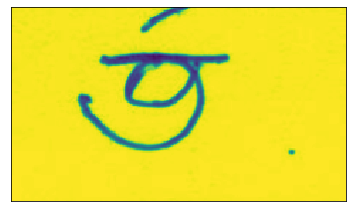

Processed image:


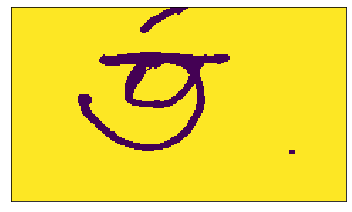

Unprocessed image:


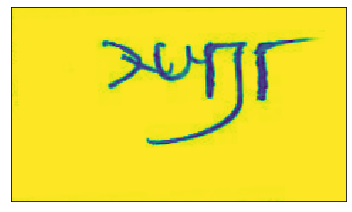

Processed image:


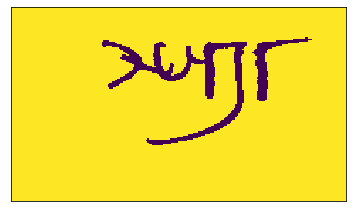

Unprocessed image:


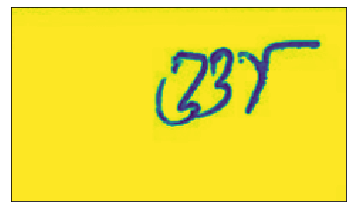

Processed image:


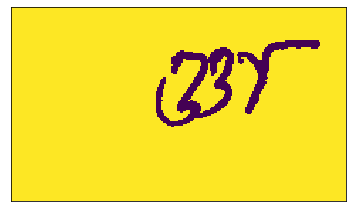

Unprocessed image:


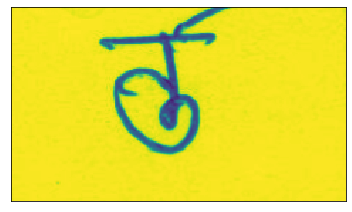

Processed image:


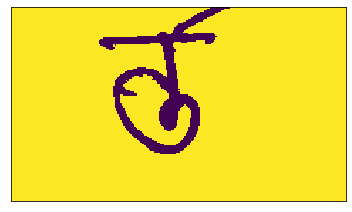

Unprocessed image:


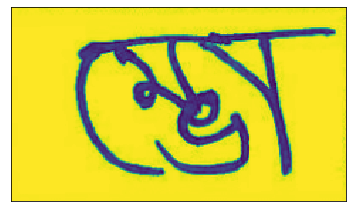

Processed image:


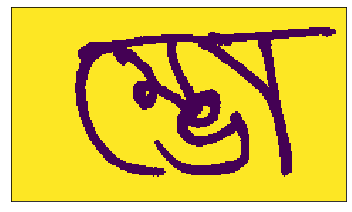

In [17]:
# Use the random numbers to pick 5 random images to show 
example_plots = np.random.randint(0, train_image_numpy.shape[0], 5)

# Plot the example images before/after bw processing
for i in example_plots:
    print('Unprocessed image:')
    plot_letter(i, train_image_numpy, vmax=255)
    print('Processed image:')
    plot_letter(i, bw_images_df_0, vmax=1)

## Exploratory Data Analysis

In [19]:
print(f'Total Number of images in training data: {train_data.shape[0]}')
print(f'Number of pixels per image: {train_image_numpy.shape[1]}')

Total Number of images in training data: 200840
Number of pixels per image: 32332


There are 200,840 images in the data, and 32,332 pixels per data.  Are there any outliers? We are especially looking for filled or empty images.

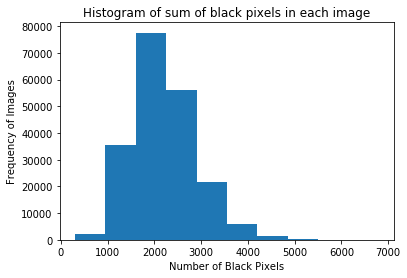

Minimum black pixels: 297
Maximum black pixels: 6808
Mean number of pixels: 2202.867845050787


In [23]:
# Plot number of 'interesting' pixels in the black and white images
sum_pixels = bw_images_df_0.shape[1] - bw_images_df_0.sum(axis=1)
plt.hist(sum_pixels)
plt.xlabel('Number of Black Pixels')
plt.ylabel('Frequency of Images')
plt.title('Histogram of sum of black pixels in each image')
plt.show()

print(f'Minimum black pixels: {sum_pixels.min()}')
print(f'Maximum black pixels: {sum_pixels.max()}')
print(f'Mean number of pixels: {sum_pixels.mean()}')

There do not appear to be any obvious outliers in this set, as kaggle has likely cleaned the data.

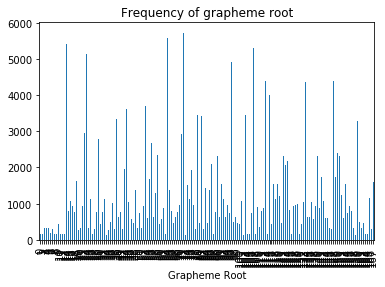

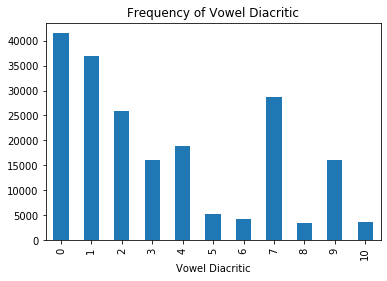

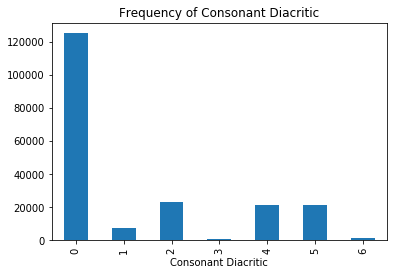

In [24]:
# Count the frequency of each type within the three categories
grapheme_root_counts = train_data.groupby(by='grapheme_root').count()
vowel_diacritic_counts = train_data.groupby(by='vowel_diacritic').count()
consonant_diacritic_counts = train_data.groupby(by='consonant_diacritic').count()

# Plot the frequency of each type within the three categories
grapheme_root_counts['grapheme'].plot(kind='bar')
plt.title('Frequency of grapheme root')
plt.xlabel('Grapheme Root')
plt.show()

vowel_diacritic_counts['grapheme'].plot(kind='bar')
plt.title('Frequency of Vowel Diacritic')
plt.xlabel('Vowel Diacritic')
plt.show()

consonant_diacritic_counts['grapheme'].plot(kind='bar')
plt.title('Frequency of Consonant Diacritic')
plt.xlabel('Consonant Diacritic')
plt.show()